In [121]:
#@title Setup
%%capture

#@test {"output": "ignore"}



import glob

BASE_DIR = "gs://download.magenta.tensorflow.org/models/music_vae/colab2"

print('Installing dependencies...')
!apt-get update -qq && apt-get install -qq libfluidsynth1 fluid-soundfont-gm build-essential libasound2-dev libjack-dev
!pip install -q pyfluidsynth
!pip install -qU magenta



# Hack to allow python to pick up the newly-installed fluidsynth lib.
# This is only needed for the hosted Colab environment.
import ctypes.util
orig_ctypes_util_find_library = ctypes.util.find_library
def proxy_find_library(lib):
  if lib == 'fluidsynth':
    return 'libfluidsynth.so.1'
  else:
    return orig_ctypes_util_find_library(lib)
ctypes.util.find_library = proxy_find_library


print('Importing libraries and defining some helper functions...')
from google.colab import files
import magenta.music as mm
from magenta.models.music_vae import configs
from magenta.models.music_vae.trained_model import TrainedModel
import numpy as np
import os
import tensorflow.compat.v1 as tf
import note_seq

tf.disable_v2_behavior()

# Necessary until pyfluidsynth is updated (>1.2.5).
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

def play(note_sequence):
  mm.play_sequence(note_sequence, synth=mm.fluidsynth)

def plot(note_sequence):
  note_seq.plot_sequence(note_sequence)

def interpolate(model, start_seq, end_seq, num_steps, max_length=32,
                assert_same_length=True, temperature=0.5,
                individual_duration=4.0):
  """Interpolates between a start and end sequence."""
  note_sequences = model.interpolate(
      start_seq, end_seq,num_steps=num_steps, length=max_length,
      temperature=temperature,
      assert_same_length=assert_same_length)

  print('Start Seq Reconstruction')
  play(note_sequences[0])
  print('End Seq Reconstruction')
  play(note_sequences[-1])
  print('Mean Sequence')
  play(note_sequences[num_steps // 2])
  print('Start -> End Interpolation')
  interp_seq = mm.sequences_lib.concatenate_sequences(
      note_sequences, [individual_duration] * len(note_sequences))
  play(interp_seq)
  mm.plot_sequence(interp_seq)
  return interp_seq if num_steps > 3 else note_sequences[num_steps // 2]

def download(note_sequence, filename):
  mm.sequence_proto_to_midi_file(note_sequence, filename)
  files.download(filename)

print('Done')

In [133]:
class CustomTrainedModel(TrainedModel):
  

    # we want to override the interpolation method in the future. We can also override any other method like sample/encode/decode if needed
  def interpolate(self, start_sequence, end_sequence, num_steps, length=None, temperature=1.0, assert_same_length=True):
    print("AIOOOO MBARE, THIS IS A TEST TO CHECK WETHER THIS METHOD IS ACTUALLY OVERRIDEN")

    '''Interpolates between a start and an end NoteSequence.
    Args:
      start_sequence: The NoteSequence to interpolate from.
      end_sequence: The NoteSequence to interpolate to.
      num_steps: Number of NoteSequences to be generated, including the
        reconstructions of the start and end sequences.
      length: The maximum length of a sample in decoder iterations. Required
        if end tokens are not being used.
      temperature: The softmax temperature to use (if applicable).
      assert_same_length: Whether to raise an AssertionError if all of the
        extracted sequences are not the same length.
    Returns:
      A list of interpolated NoteSequences.
    Raises:
      AssertionError: If `assert_same_length` is True and any extracted
        sequences differ in length.
    '''

    #In this case the original interpolation method """Spherical linear interpolation.""". We can easily replace this one.
    def _slerp(p0, p1, t):
      """Spherical linear interpolation."""
      omega = np.arccos(np.dot(np.squeeze(p0/np.linalg.norm(p0)),
                                np.squeeze(p1/np.linalg.norm(p1))))
      so = np.sin(omega)
      return np.sin((1.0-t)*omega) / so * p0 + np.sin(t*omega)/so * p1

    _, mu, _ = self.encode([start_sequence, end_sequence], assert_same_length)
    z = np.array([_slerp(mu[0], mu[1], t)
                for t in np.linspace(0, 1, num_steps)])
    return self.decode(length=length, z=z, temperature=temperature)

  def distance(self, z_array):
    ''' Computes the distance vectors between points in the latent space.
    Args:
      z_array: The array of points. Must be of shape (n_samples, n_dims).
    Returns:
      displacement: List of vectors, each pointing from one point to the next.
      distance: Distance from each point to the next (norm of its vector).
    '''
    n_samples = np.shape(z_array)[0]
    displacement = [0]*(n_samples-1)
    distance = [0]*(n_samples-1)
    for i in range(n_samples-1):  
      displacement[i] = z_array[i+1] - z_array[i]
      distance[i] = np.linalg.norm(displacement[i])
    return displacement, distance

  def cos_angle(self, displacement):
    ''' Computes the cosine of the angle between pairs of neighboring 
    displacement vectors.
    Args:
      displacement: List of vectors between pairs of neighboring points in 
      the latent space. First output of distance().
    Returns:
      cos_angle: Numpy array of cosines of angles between neighboring 
      displacement vectors.
    '''
    n_displacements = len(displacement)
    cos_angle = np.zeros(n_displacements-1)
    for i in range(n_displacements-1):
      cos_angle[i] = np.dot(displacement[i+1], displacement[i]) \
                        / (np.linalg.norm(displacement[i+1]) * np.linalg.norm(displacement[i]))
    return cos_angle


In [135]:
# Define Model
%%capture

hierdec_trio_16bar_config = configs.CONFIG_MAP['hierdec-trio_16bar']
model_16bar = CustomTrainedModel(hierdec_trio_16bar_config, batch_size=4, checkpoint_dir_or_path=BASE_DIR + '/checkpoints/trio_16bar_hierdec.ckpt')

In [124]:
# --- TrainedModel.sample ---
# input: n (number of sequences), softmax temperature
# returns: a list of note sequences
n = 100
temperature = 1
samples = model_16bar.sample(n=n, temperature=temperature)
print('Number of samples:',len(samples))

print('Sample object type:',type(samples[0]))

# note sequences can be plotted with plot() and played with play()
print('')
print('----- Actual samples -----')
for ns in samples[0:5]:
  plot(ns)
  play(ns)

# --- TrainedModel.encode ---
# input: a list of NoteSequences
# returns: tuple of shape (3, n_sequences, num_latent_dims), where the first dim is z/mu/sigma
z, mu, sigma =  model_16bar.encode(samples)

print('Shape of encoded latent vector:',np.shape(z))
'''
# --- TrainedModel.decode ---
# input: a list of latent vectors
# returns: a list of note sequences
reconstructed_samples = model_16bar.decode(z)
print('Number of samples:',len(reconstructed_samples))
print('Sample object type:',type(reconstructed_samples[0]))
print('')
print('----- Reconstructed samples -----')
for ns in reconstructed_samples:
  plot(ns)
  play(ns)
'''

Number of samples: 100
Sample object type: <class 'note_seq.protobuf.music_pb2.NoteSequence'>

----- Actual samples -----


Shape of encoded latent vector: (100, 512)


"\n# --- TrainedModel.decode ---\n# input: a list of latent vectors\n# returns: a list of note sequences\nreconstructed_samples = model_16bar.decode(z)\nprint('Number of samples:',len(reconstructed_samples))\nprint('Sample object type:',type(reconstructed_samples[0]))\nprint('')\nprint('----- Reconstructed samples -----')\nfor ns in reconstructed_samples:\n  plot(ns)\n  play(ns)\n"

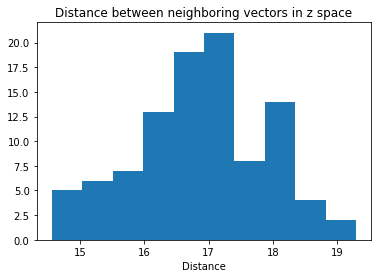

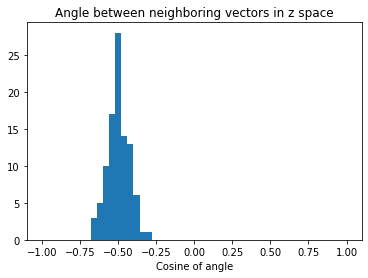

In [136]:
from matplotlib import pyplot as plt

v, d = model_16bar.distance(mu)
c = model_16bar.cos_angle(v)

plt.figure(1)
plt.hist(d)
plt.title('Distance between neighboring vectors in z space')
plt.xlabel('Distance')

plt.figure(2)
plt.hist(c, bins=50, range=[-1,1])
plt.title('Angle between neighboring vectors in z space')
plt.xlabel('Cosine of angle')
plt.show()